## Configuring the workspace
Assicurarsi di aver installato tutti le librerie necessarie per eseguire gli script all'interno del notebook

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# Creo la cartella data per salvare i dataset
if not os.path.exists("data"):
    os.makedirs("data")

os.chdir("data")

# Heart Failure Prediction Dataset
Le malattie cardiovascolari (CVD) sono la prima causa di morte a livello globale, con circa 17,9 milioni di vite all'anno, pari al 31% di tutti i decessi nel mondo. Quattro decessi su 5 per CVD sono dovuti ad attacchi di cuore e ictus, e un terzo di questi decessi avviene prematuramente in persone di età inferiore ai 70 anni. L'insufficienza cardiaca è un evento comune causato da CVD e questo set di dati contiene 11 caratteristiche che possono essere utilizzate per prevedere una possibile malattia cardiaca.

Le persone affette da malattie cardiovascolari o ad alto rischio cardiovascolare (per la presenza di uno o più fattori di rischio come ipertensione, diabete, iperlipidemia o malattie già conclamate) hanno bisogno di una diagnosi e di una gestione precoci, per le quali un modello di apprendimento automatico può essere di grande aiuto.

In [3]:
if not os.path.exists("heart.csv"):
    # Download the dataset
    !kaggle datasets download -d fedesoriano/heart-failure-prediction
    !unzip heart-failure-prediction.zip

In [4]:
df = pd.read_csv("heart.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


**Attributi del Dataset**
- Age: età del paziente [anni]
- Sex: sesso del paziente 
    - M: Maschio
    - F: Femmina
- ChestPainType: tipo di dolore toracico 
    - TA: Angina* Tipica
    - ATA: Angina Atipica
    - NAP: Dolore Non Anginoso
    - ASY: Asintomatico
- RestingBP: pressione sanguigna a riposo [mm Hg]
- Cholesterol: colesterolo sierico [mg/dl]
- FastingBS: glicemia a digiuno 
    - 1: se FastingBS > 120 mg/dl
    - 0: altrimenti
- RestingECG: risultati dell'elettrocardiogramma a riposo 
    - Normal: Normale
    - ST: presenza di anomalia dell'onda ST-T (inversioni dell'onda T e/o elevazione o depressione del segmento ST di > 0,05 mV)
    - LVH: mostra probabile o definita ipertrofia ventricolare sinistra secondo i criteri di Estes
- MaxHR: frequenza cardiaca massima raggiunta [valore numerico tra 60 e 202]
- ExerciseAngina: angina* indotta da esercizio 
    - Y: Sì
    - N: No
- Oldpeak: oldpeak = ST [valore numerico misurato in depressione]
- ST_Slope: inclinazione del segmento ST durante l'esercizio 
    - Up: inclinato verso l'alto
    - Flat: piatto
    - Down: inclinato verso il basso
- HeartDisease: classe di uscita 
    - 1: malattia cardiaca
    - 0: Normale

_*Il termine Angina Pectoris deriva dai termini latini Angina=dolore e Pectoris=petto. Si tratta, in effetti, di una sindrome caratterizzata da dolore in regione retrosternale, talvolta irradiato al lato ulnare del braccio sinistro e alle spalle. [wiki](https://www.my-personaltrainer.it/cardiopatia-ischemica/angina.html)_

In [6]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [7]:
categorical = [
    "Sex",
    "ChestPainType",
    "FastingBS",
    "RestingECG",
    "ExerciseAngina",
    "ST_Slope",
]

Possiamo notare che il dataset sembra essere leggermente sbilanciato sugli esempi negativi, con i pazienti affetti da malattia cardiaca.  
Questo potrebbe essere un bene perchè il predittore sarà più preciso nella predizione del caso negativo.

<Axes: xlabel='HeartDisease', ylabel='count'>

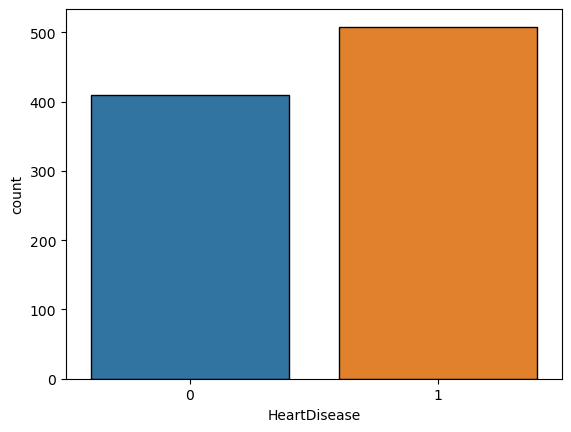

In [8]:
sns.countplot(df, x="HeartDisease", edgecolor="black", hue="HeartDisease", legend=False)

Facendo una panoramica su tutti gli attributi categorici, possiamo notare che:
- Il dataset contiene molti più maschi.
- Molti pazienti sono asintomatici rispetto ai dolori al petto
- Molti non hanno problemi di glicemia a digiuno
- Molti hanno un elettrocardiogramma apparentemente normale
- La maggior parte delle persone è asintomatica al dolore anche durante l'esercizio fisico
- Sempre durante l'esercizio fisico, abbiamo pochi casi con il segmento ST basso

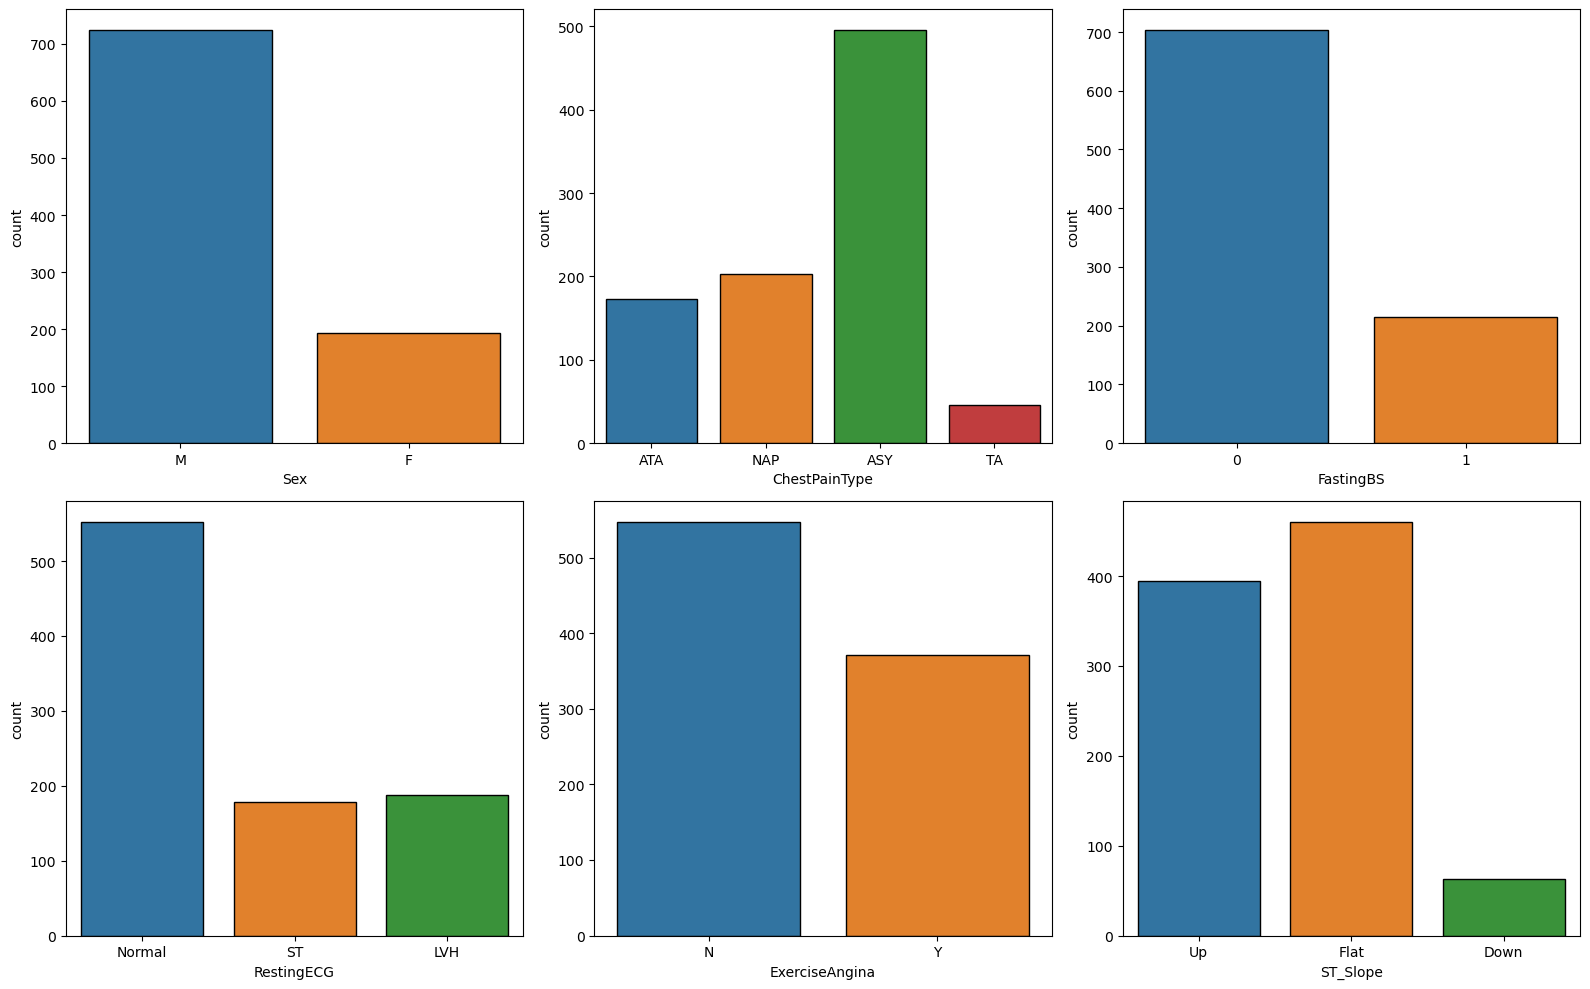

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

for i, col in enumerate(categorical):
    sns.countplot(
        df, x=col, ax=axs[i // 3, i % 3], edgecolor="black", hue=col, legend=False
    )
plt.tight_layout()

In [10]:
numerical = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]

Dando un'occhiata alle distribuzioni degli attributi numerici, notiamo che:
- L'età ben distribuita con qualche picco, ma niente di anomalo
- La pressione sangiugna a di sicuro qualche outlier e anche vari picchi strani, ma la forma rimane comunque unimodale
- Il colesterolo ha tanti pazienti con valore zero, il che è abbastanza strano
- La frequenza cardiaca massima ha una buona distribuzione, forse leggermente bimodale
- Il valore di Oldpeak sembra che abbia degli outlier e molti pazienti con il valore 0

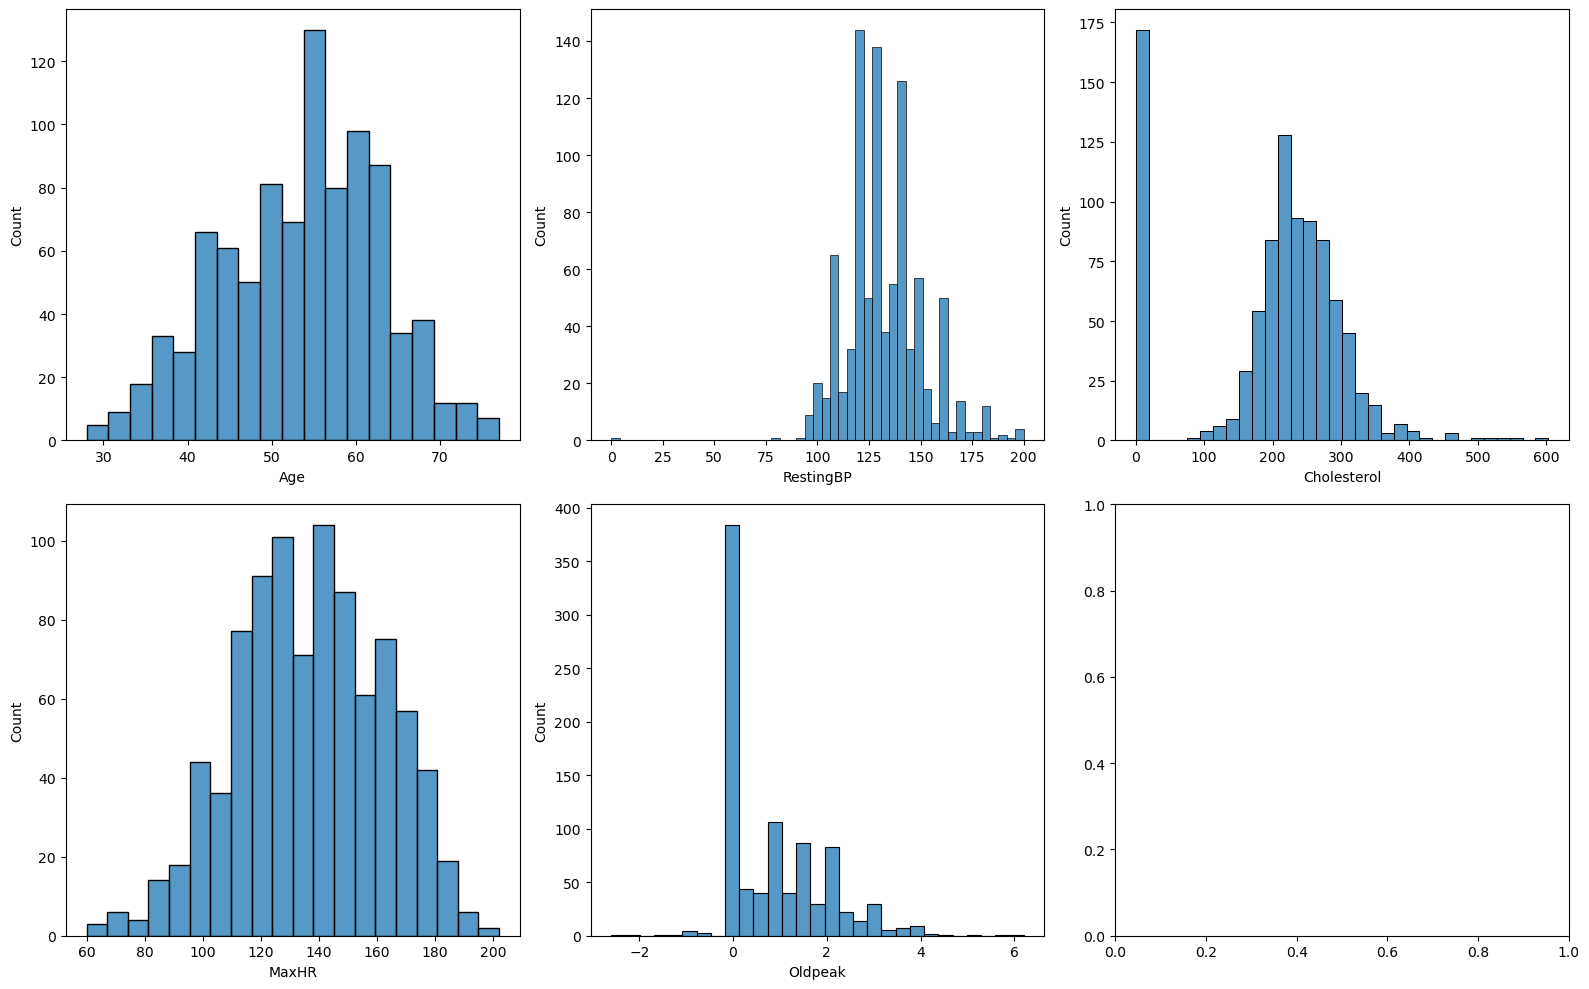

In [11]:
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

for i, col in enumerate(numerical):
    sns.histplot(df, x=col, ax=axs[i // 3, i % 3])
plt.tight_layout()

Di seguito possiamo notare la forma delle varie distribuzioni.

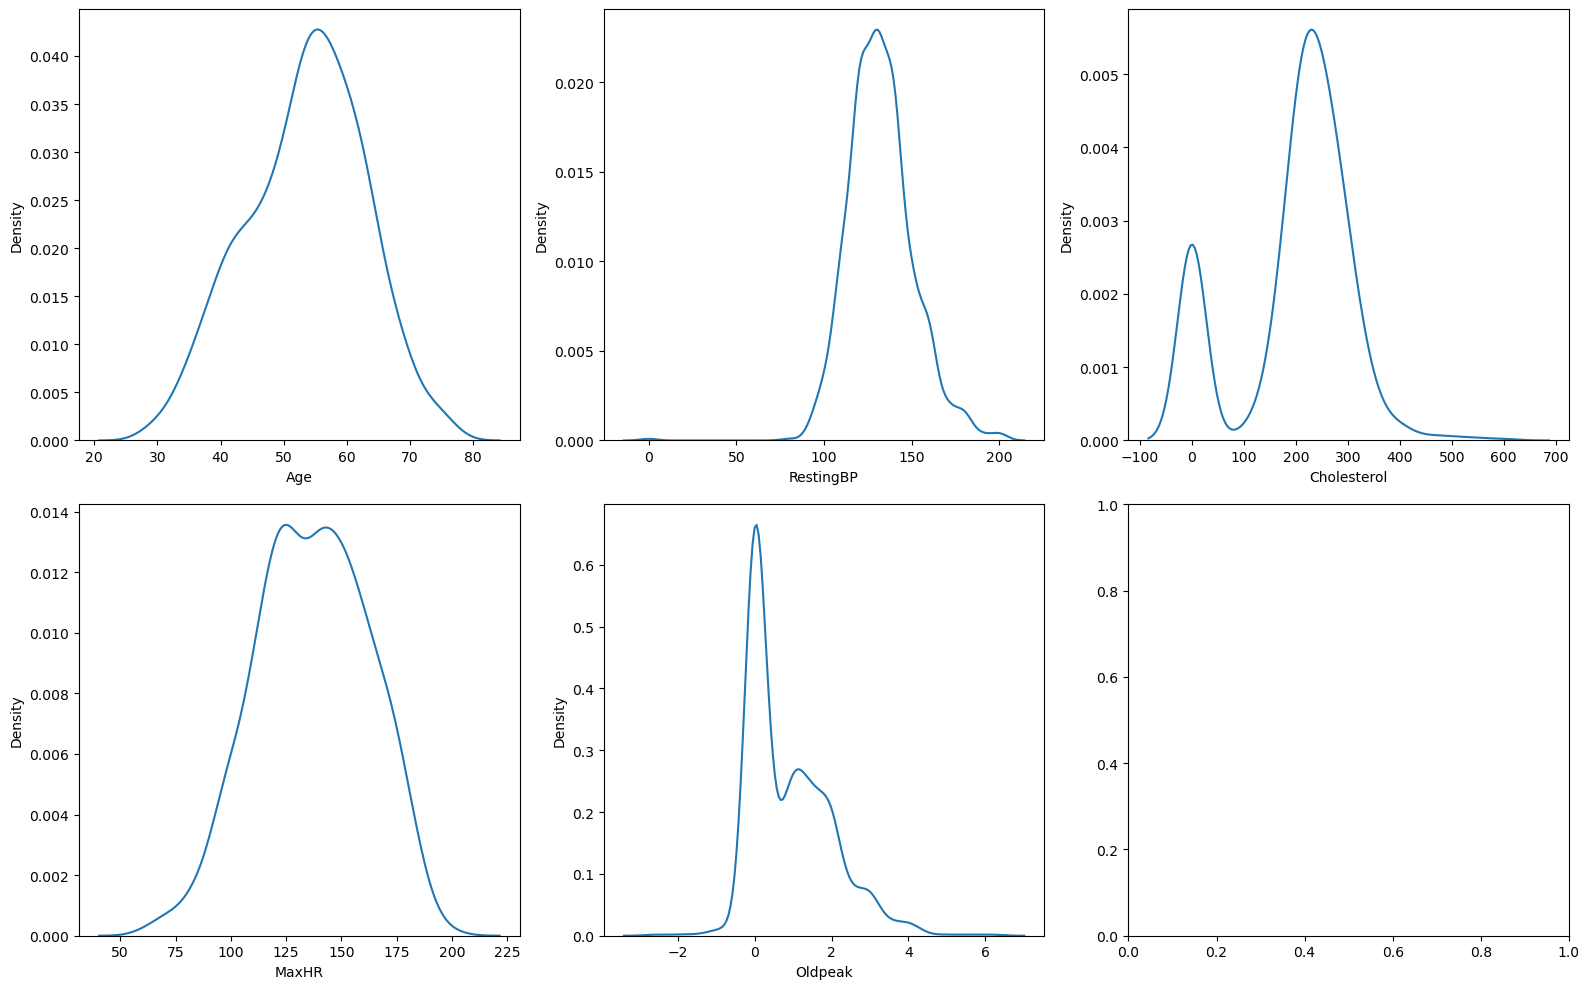

In [12]:
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

for i, col in enumerate(numerical):
    sns.kdeplot(df, x=col, ax=axs[i // 3, i % 3])
plt.tight_layout()

# Analisi Miss Values

In [13]:
# Apparentemente sembra che non ci siano valori mancanti
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [14]:
# Andando a guardere però i valori pari a 0, notiamo alcune anomalie
df[numerical].where(df[numerical] == 0).count()

Age              0
RestingBP        1
Cholesterol    172
MaxHR            0
Oldpeak        368
dtype: int64

Di seguito, le valutazioni correlate:
- La __pressione sanguigna__ ha un paziente con il valore 0, il che sembra una misurazione errata.
- Alcuni pazienti hanno il __colesterolo__ pari a 0, il che è impossibile.
- Tanti pazienti hanno questo valore di Oldpeak pari a 0 che però può essere un valore accettabile: indica una sorta di depressione toracica nulla e quindi nella norma.  
_Forse si potrebbe valutare comunque come una misurazione errata perchè sembra strano che tanti pazienti abbiano la depressione toracica identica._   
_D'altro canto si potrebbe dare la motivazione alla misurazione poco precisa e quindi lo strumente potrebbe non aver colto le leggere differenze tra i pazienti._

In conclusione è stato deciso di considerare i valori 0 come valori mancanti per gli attributi RestingBP e Cholesterol.  
Per l'attributo Oldpeak considerò i valori 0 come un paziente avente una depressione toracica nella norma. Anche perchè altrimenti avrei dovuto lavorare con metà del dataset.

In [15]:
# Infatti il valore minimo di colesterolo dopo lo zero, è abbastanza lontano dallo zero
df[(df["Cholesterol"] > 0) & (df["Cholesterol"] < 100)]["Cholesterol"]

98    85
Name: Cholesterol, dtype: int64

Consideriamo quindi il dataset senza questi valori mancanti, per essere sicuri delle valutazioni che faremo

In [16]:
col_with_zeros = ["Cholesterol", "RestingBP"]
df_clean = df.copy()
df_clean[col_with_zeros] = df_clean[col_with_zeros].replace(0, np.nan)
df_clean.dropna(inplace=True)
print(f"Numero di righe prima: {df.shape[0]}")
print(f"Numero di righe dopo: {df_clean.shape[0]}")
df_clean.describe()

Numero di righe prima: 918
Numero di righe dopo: 746


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000
mean,52.882038,133.022788,244.635389,0.167560,140.226542,0.901609,0.477212
std,9.505888,17.282750,59.153524,0.373726,24.524107,1.072861,0.499816
min,28.000000,92.000000,85.000000,0.000000,69.000000,-0.100000,0.000000
25%,46.000000,120.000000,207.250000,0.000000,122.000000,0.000000,0.000000
50%,54.000000,130.000000,237.000000,0.000000,140.000000,0.500000,0.000000
75%,59.000000,140.000000,275.000000,0.000000,160.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Notiamo subito che il dataset probabilmente era stato gonfiato per creare più casi di malattie cardiache.  
Infatti il dataset senza valori mancanti è più bilanciato con leggermente più pazienti sani.

<Axes: xlabel='HeartDisease', ylabel='count'>

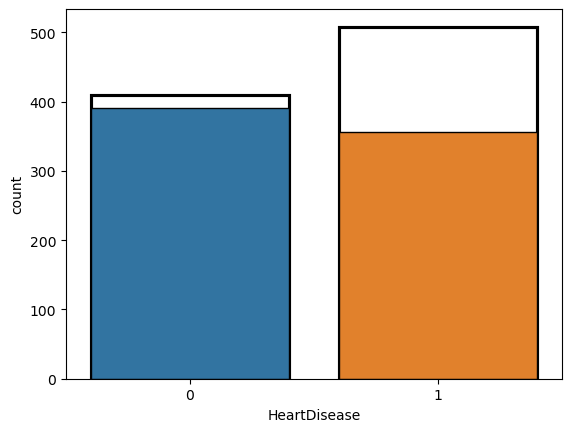

In [17]:
sns.countplot(df, x="HeartDisease", fill=False, edgecolor="black")
sns.countplot(
    df_clean, x="HeartDisease", hue="HeartDisease", edgecolor="black", legend=False
)

Per ogni attributo categorico possiamo dire:
- Molti pazienti con valori mancanti era maschio, quindi diminuisce la differenza di frequenza tra genere che rimane comunque abbastanza marcata.
- Diminuiscono gli asintomatici rispetto al dolore al petto
- I problemi di glicemia sono rimasti invariati
- Diminuiscono i pazienti con elettrocardiogramma normale
- Diminuiscono gli asintomatici da dolore al petto durante l'esercizio
- Il segmento ST rimane invariato

Dopo queste considerazioni, possiamo ipotizzare che il dataset possa essere stato sovracampionato (oversampling) di pazienti con malattie al cuore asintomatiche.

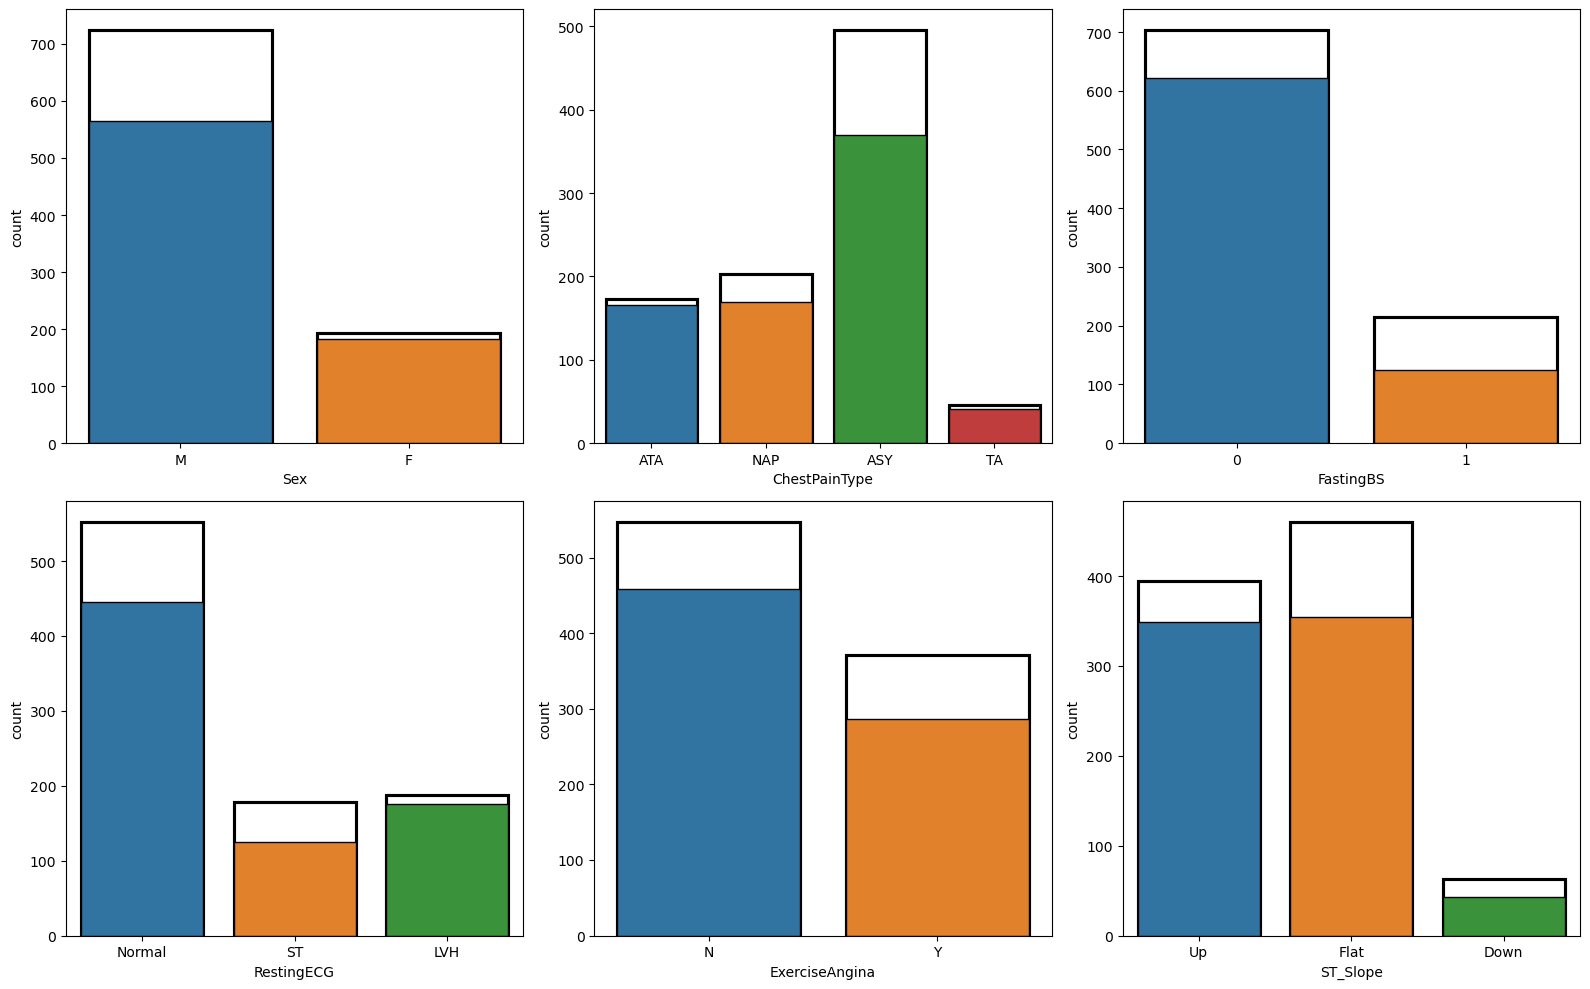

In [18]:
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

for i, col in enumerate(categorical):
    sns.countplot(df, x=col, ax=axs[i // 3, i % 3], fill=False, edgecolor="black")
    sns.countplot(
        df_clean,
        x=col,
        ax=axs[i // 3, i % 3],
        edgecolor="black",
        hue=col,
        legend=False,
    )
plt.tight_layout()

Ad occhio sembra che le distribuzioni dei vari attributi numerici siano diventate più compatte, cone meno picchi o comunque meno accentuati.

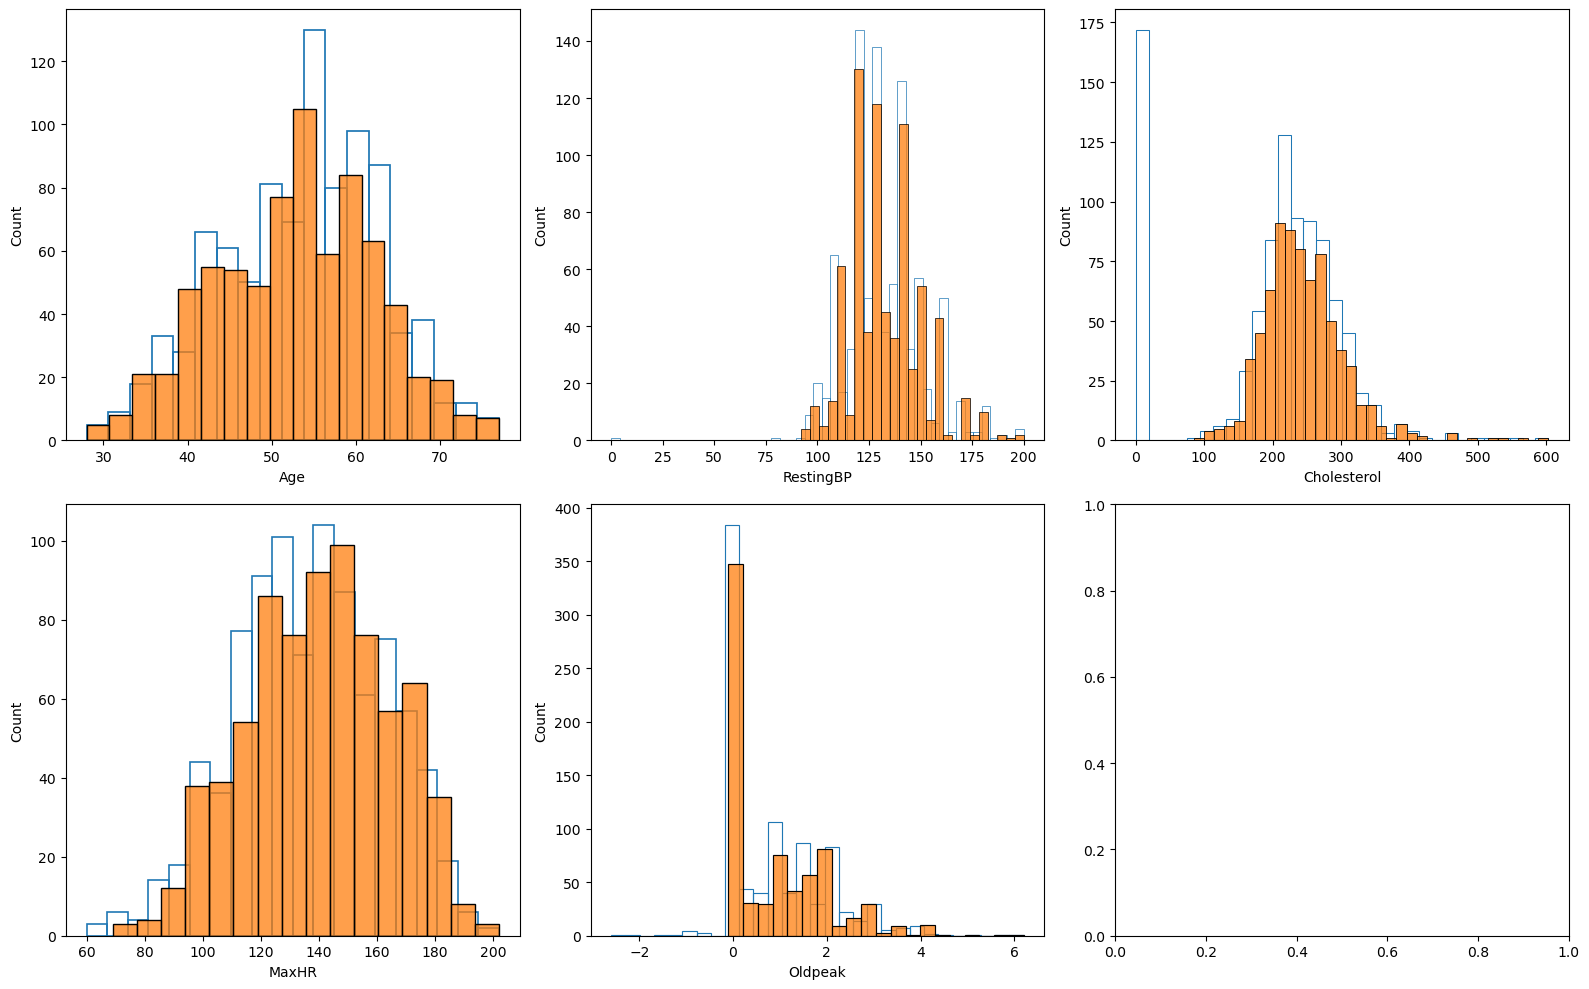

In [19]:
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

for i, col in enumerate(numerical):
    sns.histplot(df, x=col, fill=False, ax=axs[i // 3, i % 3])
    sns.histplot(df_clean, x=col, ax=axs[i // 3, i % 3])
plt.tight_layout()

Diciamo che la forma delle distribuzioni diventano più normali, tranne l'attributo di OldPeak che ha tanti valori pari a 0.

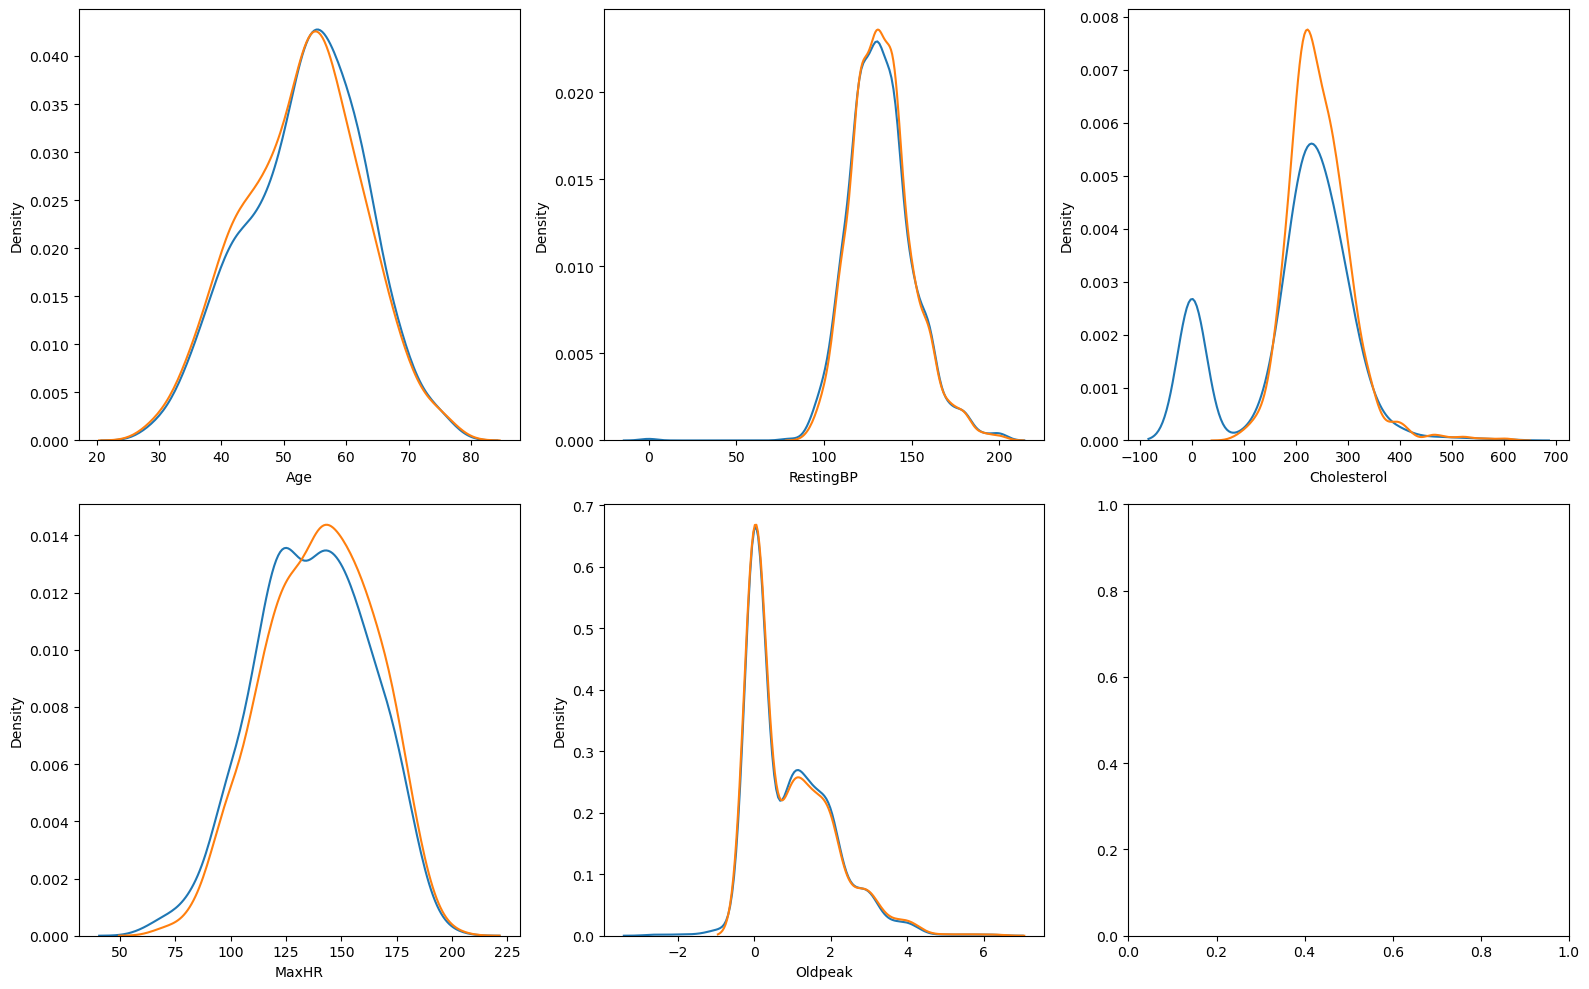

In [20]:
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

for i, col in enumerate(numerical):
    sns.kdeplot(df, x=col, fill=False, ax=axs[i // 3, i % 3])
    sns.kdeplot(df_clean, x=col, ax=axs[i // 3, i % 3])
plt.tight_layout()

# Misure di centralità
Come misure di centralità sono state scelte la moda per gli attributi categorici.  
Mentre per gli attributi numerici la mediana, essendo un valore robusto.  
Si può notare che la mediana risulta vicina alla media di quasi tutte le distribuzione, a differenza del colesterolo (poca varianza) e OldPeak (per quel il valore 0 molto frequente)

In [21]:
# Per gli attributi categorici usiamo la moda come misura di centralità

print(f"La moda per la variabile Sex è {df_clean['Sex'].mode()[0]}")
print(f"La moda per la variabile ChestPainType è {df_clean['ChestPainType'].mode()[0]}")
print(f"La moda per la variabile FastingBS è {df_clean['FastingBS'].mode()[0]}")
print(f"La moda per la variabile RestingECG è {df_clean['RestingECG'].mode()[0]}")
print(
    f"La moda per la variabile ExerciseAngina è {df_clean['ExerciseAngina'].mode()[0]}"
)
print(f"La moda per la variabile ST_Slope è {df_clean['ST_Slope'].mode()[0]}")
print(f"La moda per la variabile HeartDisease è {df_clean['HeartDisease'].mode()[0]}\n")

# Per gli attributi numerici usiamo la media come misura di centralità
# TODO: da definire le misure di centralità

print(
    f"La mediana per la variabile Age è {df_clean['Age'].median()} e il range IQR è [{df_clean['Age'].quantile(0.25)} - {df_clean['Age'].quantile(0.75)}]"
)
print(
    f"La mediana per la variabile RestingBP è {df_clean['RestingBP'].median()} e il range IQR è [{df_clean['RestingBP'].quantile(0.25)} - {df_clean['RestingBP'].quantile(0.75)}]"
)
print(
    f"La mediana per la variabile Cholesterol è {df_clean['Cholesterol'].median()} e il range IQR è [{df_clean['Cholesterol'].quantile(0.25)} - {df_clean['Cholesterol'].quantile(0.75)}]"
)
print(
    f"La mediana per la variabile MaxHR è {df_clean['MaxHR'].median()} e il range IQR è [{df_clean['MaxHR'].quantile(0.25)} - {df_clean['MaxHR'].quantile(0.75)}]"
)
print(
    f"La mediana per la variabile Oldpeak è {df_clean['Oldpeak'].median()} e il range IQR è [{df_clean['Oldpeak'].quantile(0.25)} - {df_clean['Oldpeak'].quantile(0.75)}]\n"
)

df_clean[numerical].describe()

La moda per la variabile Sex è M
La moda per la variabile ChestPainType è ASY
La moda per la variabile FastingBS è 0
La moda per la variabile RestingECG è Normal
La moda per la variabile ExerciseAngina è N
La moda per la variabile ST_Slope è Flat
La moda per la variabile HeartDisease è 0

La mediana per la variabile Age è 54.0 e il range IQR è [46.0 - 59.0]
La mediana per la variabile RestingBP è 130.0 e il range IQR è [120.0 - 140.0]
La mediana per la variabile Cholesterol è 237.0 e il range IQR è [207.25 - 275.0]
La mediana per la variabile MaxHR è 140.0 e il range IQR è [122.0 - 160.0]
La mediana per la variabile Oldpeak è 0.5 e il range IQR è [0.0 - 1.5]



,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,746.000000,746.000000,746.000000,746.000000,746.000000
mean,52.882038,133.022788,244.635389,140.226542,0.901609
std,9.505888,17.282750,59.153524,24.524107,1.072861
min,28.000000,92.000000,85.000000,69.000000,-0.100000
25%,46.000000,120.000000,207.250000,122.000000,0.000000
50%,54.000000,130.000000,237.000000,140.000000,0.500000
75%,59.000000,140.000000,275.000000,160.000000,1.500000
max,77.000000,200.000000,603.000000,202.000000,6.200000


# Misure di dispersione

Guardando gli attributi categorici

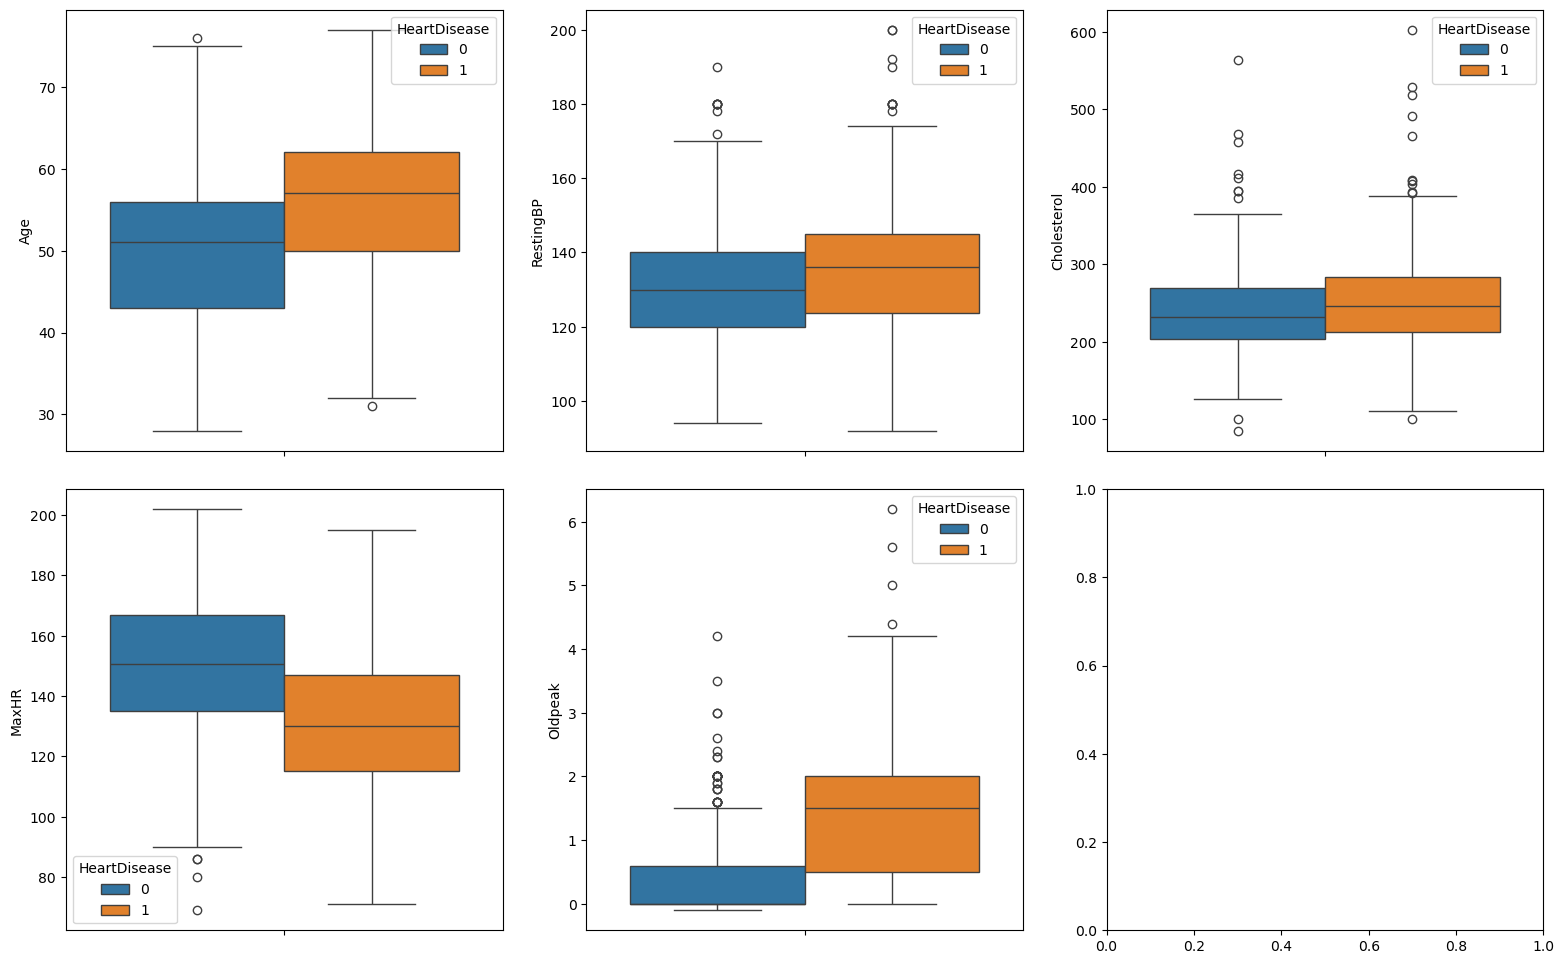

In [39]:
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

for i, col in enumerate(numerical):
    sns.boxplot(data=df_clean, y=col, hue="HeartDisease",ax=axs[i // 3, i % 3])

plt.tight_layout(pad=2)

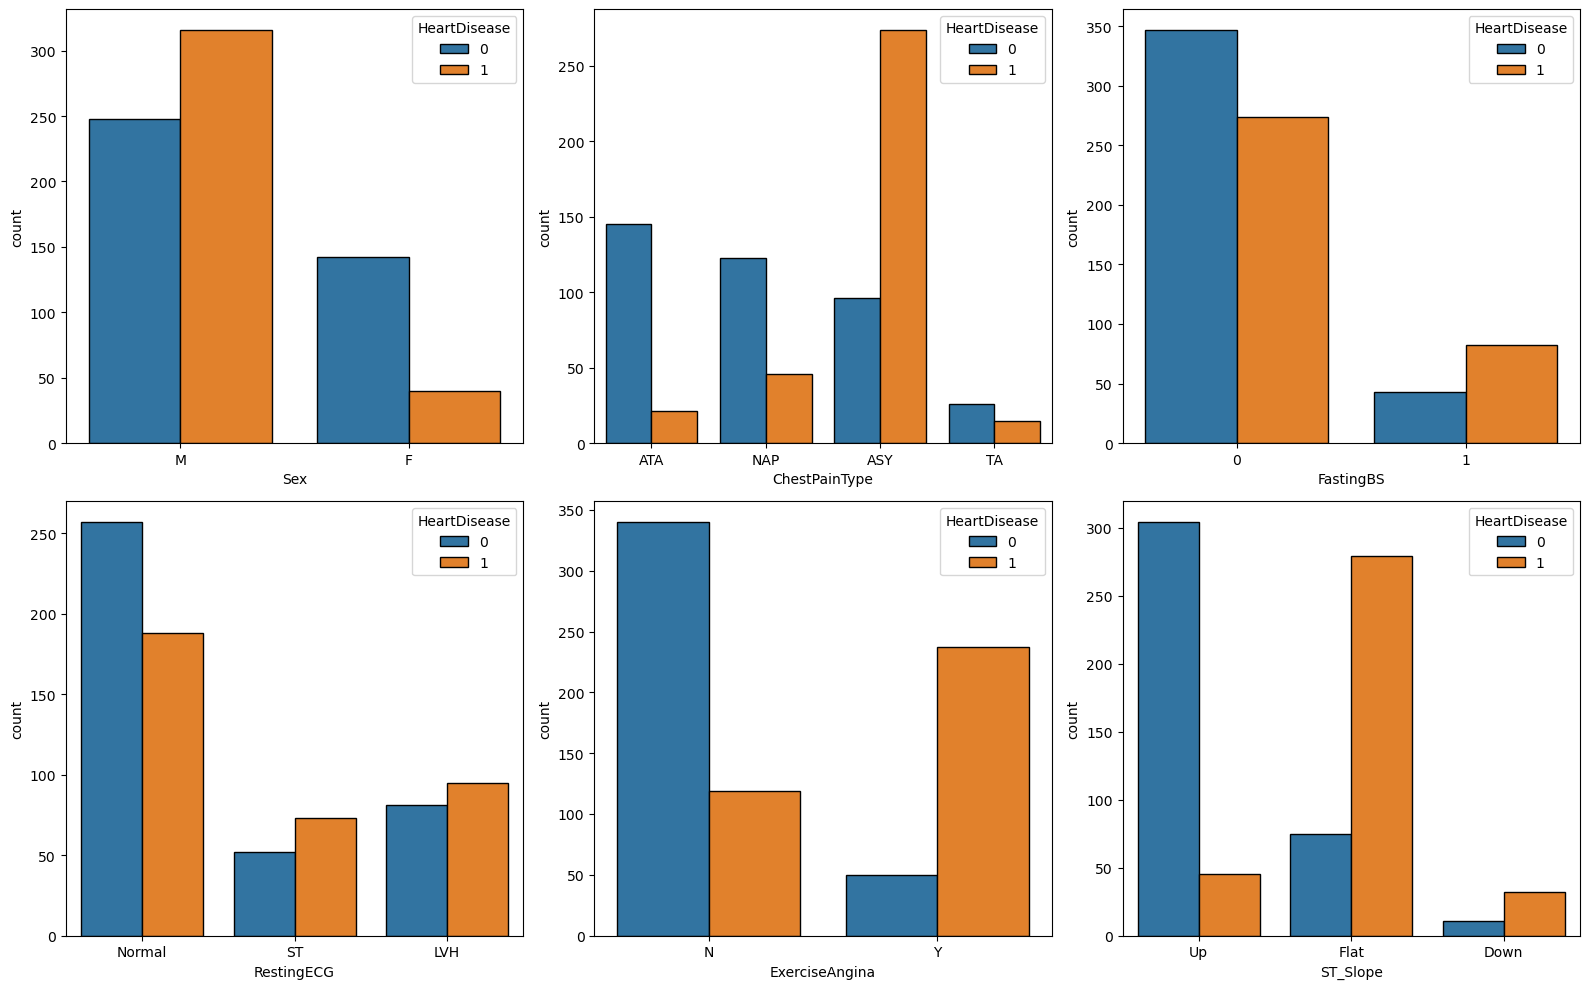

In [23]:
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

for i, col in enumerate(categorical):
    sns.countplot(
        df_clean,
        ax=axs[i // 3, i % 3],
        edgecolor="black",
        x=col,
        hue="HeartDisease",
    )
plt.tight_layout()

<Axes: xlabel='ExerciseAngina', ylabel='ChestPainType'>

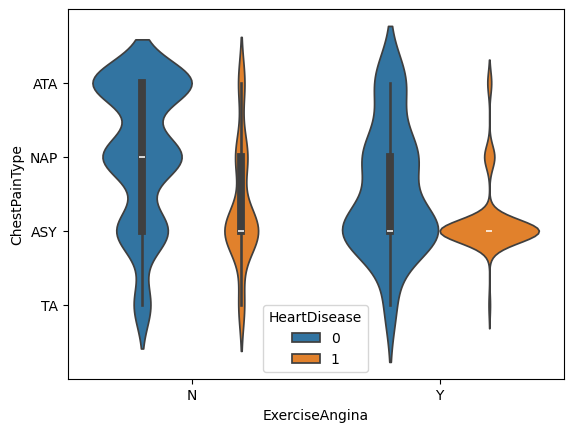

In [24]:
sns.violinplot(data=df_clean, x="ExerciseAngina", y="ChestPainType", hue="HeartDisease")

<Axes: xlabel='Sex', ylabel='ChestPainType'>

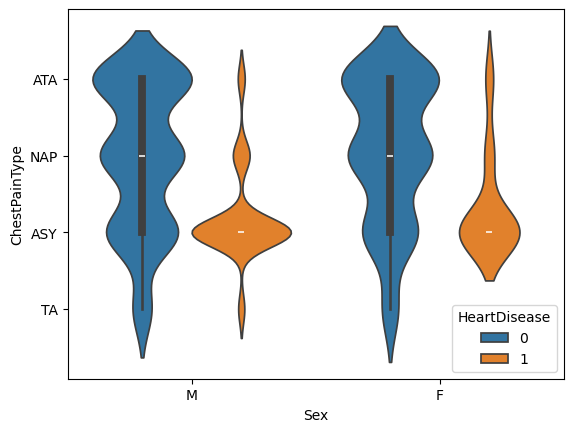

In [25]:
sns.violinplot(data=df_clean, x="Sex", y="ChestPainType", hue="HeartDisease")

# Correlations Analysis

## Correlazioni tra le variabili numeriche

Correlazione con la variabile target

In [26]:
# point biserial correlation
from scipy.stats import pointbiserialr

for col in numerical:
    corr, p = pointbiserialr(df_clean["HeartDisease"], df_clean[col])
    if p < 0.05:
        print(
            f"La correlazione è significativa tra HeartDisease e {col} (correlazione {corr} e p-value {p})"
        )
    else:
        print(
            f"Non possiamo dire nulla sulla correlazione tra HeartDisease e {col} (correlazione {corr} e p-value {p})"
        )

La correlazione è significativa tra HeartDisease e Age (correlazione 0.29861668487267484 e p-value 7.861071765823028e-17)
La correlazione è significativa tra HeartDisease e RestingBP (correlazione 0.17324158155012143 e p-value 1.9373836240386295e-06)
La correlazione è significativa tra HeartDisease e Cholesterol (correlazione 0.10386559562465594 e p-value 0.004514069106741989)
La correlazione è significativa tra HeartDisease e MaxHR (correlazione -0.37721219001674333 e p-value 1.2269260081362859e-26)
La correlazione è significativa tra HeartDisease e Oldpeak (correlazione 0.4956962549378697 e p-value 1.630293971174312e-47)


Correlazione tra gli attributi numerici

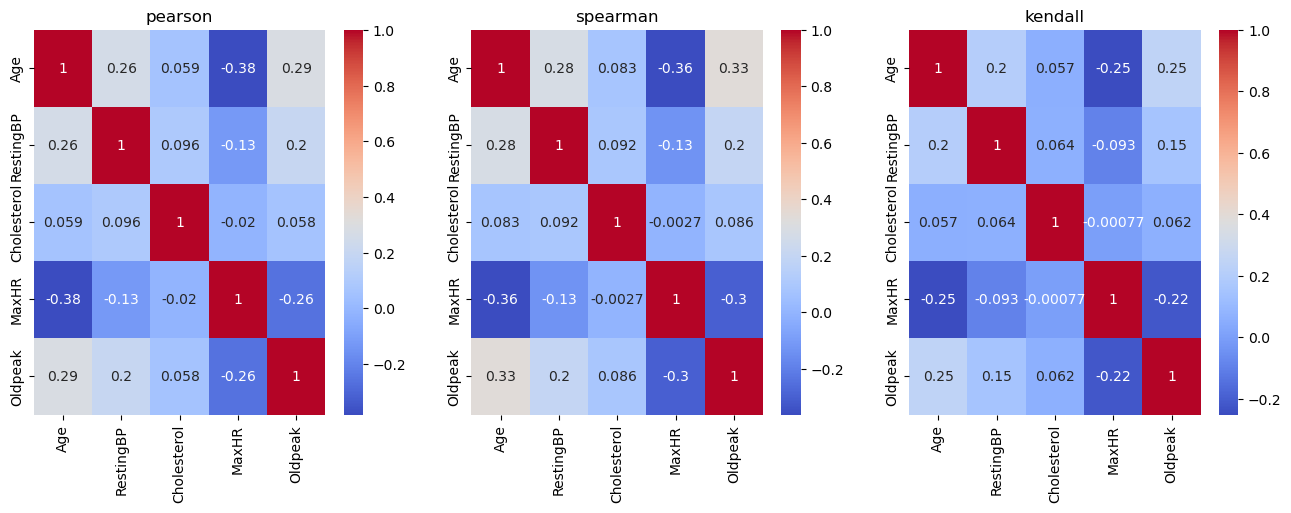

In [40]:
methods = ["pearson", "spearman", "kendall"]
fig, axs = plt.subplots(1, 3, figsize=(16, 5))

for i, method in enumerate(methods):
    sns.heatmap(
        df_clean[numerical].corr(method=method),
        annot=True,
        ax=axs[i],
        cmap="coolwarm",
    )
    axs[i].set_title(method)

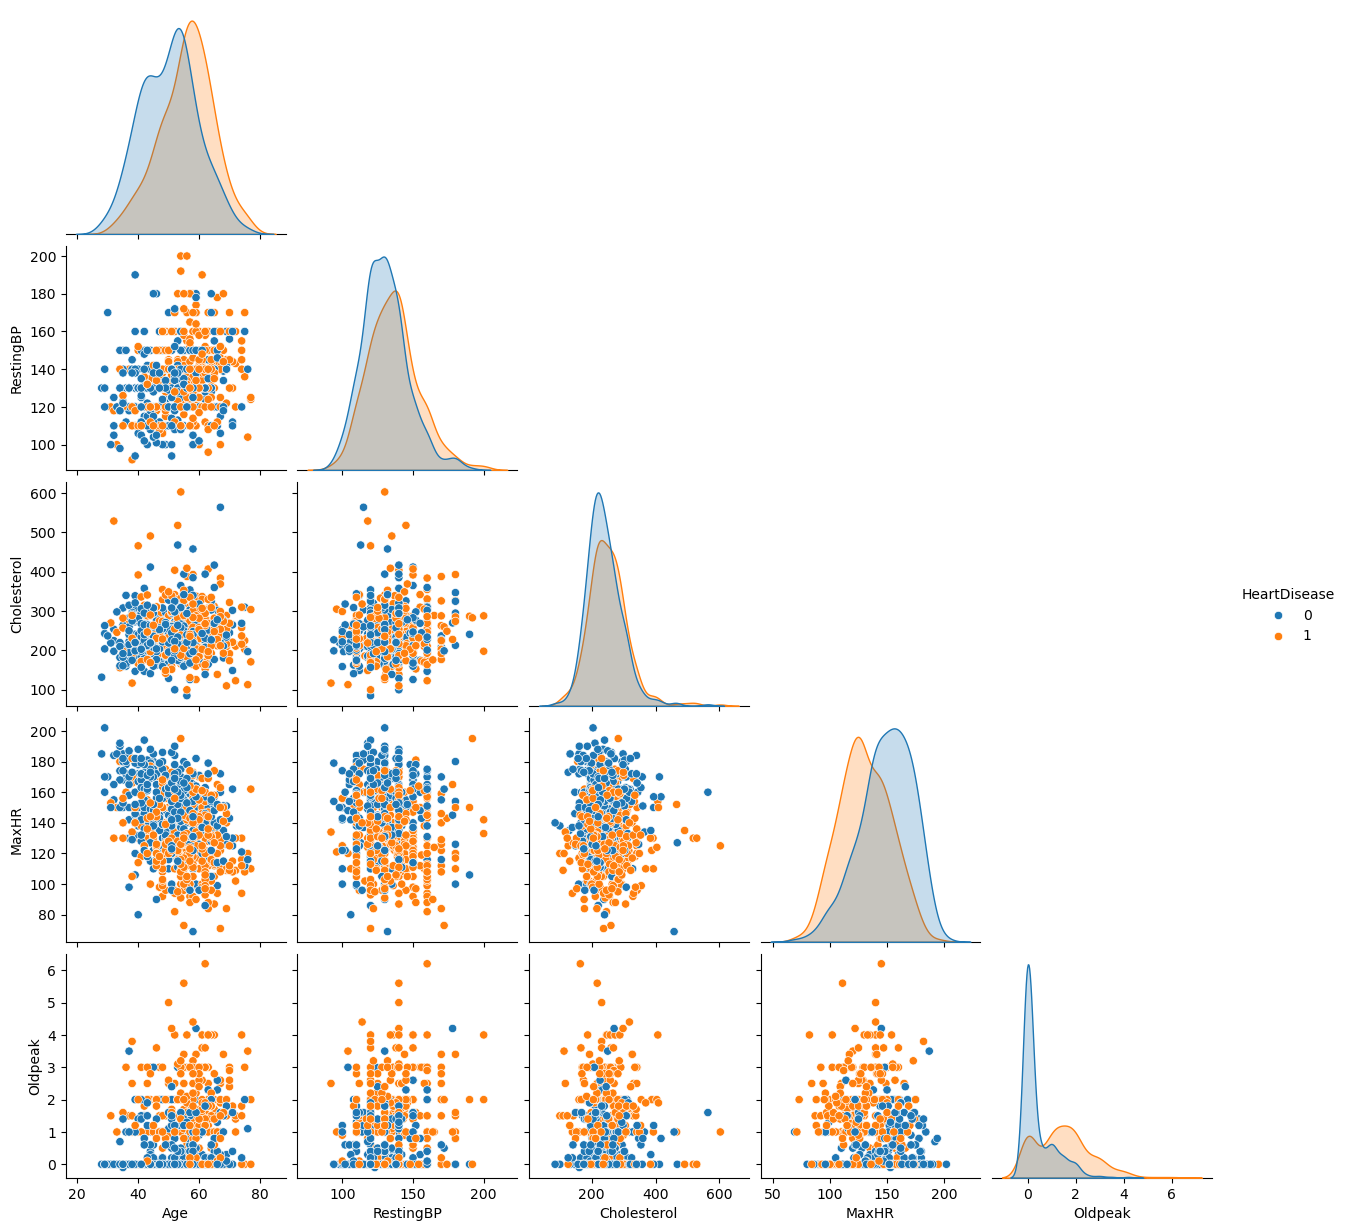

In [30]:
sns.pairplot(
    data=df_clean[numerical + ["HeartDisease"]], hue="HeartDisease", corner=True
)

## Tabelle di contingenza tra attributi categorici e variabile target

In [45]:
def contingency_table_analysis(df, target, col, ax):
    contingency_table = pd.crosstab(df[target], df[col])
    stat, p, dof, expected = chi2_contingency(contingency_table)

    print(f"I valori attesi della tabella di contingenza sarebbero:\n {expected}\n")
    print(
        f"Il coefficient di correlazione è {stat} mentre il grado di libertà è {dof}\n"
    )

    annot = np.empty_like(contingency_table).astype(str)
    for i in range(contingency_table.shape[0]):
        for j in range(contingency_table.shape[1]):
            c = contingency_table.iloc[i, j]
            e = expected[i, j]
            annot[i, j] = f"{c} ({e:.1f})"

    sns.heatmap(contingency_table, annot=annot, fmt="", cmap="coolwarm", ax=ax)

    alpha = 0.05
    print("Il P-value è " + str(p))
    if p <= alpha:
        print("Dependent (reject H0)")
    else:
        print("Independent (H0 holds true)")

Analisi per la variabile Sex
I valori attesi della tabella di contingenza sarebbero:
 [[ 95.14745308 294.85254692]
 [ 86.85254692 269.14745308]]

Il coefficient di correlazione è 62.58908315427757 mentre il grado di libertà è 1

Il P-value è 2.5466116402861146e-15
Dependent (reject H0)



Analisi per la variabile ChestPainType
I valori attesi della tabella di contingenza sarebbero:
 [[193.43163539  86.78284182  88.35120643  21.43431635]
 [176.56836461  79.21715818  80.64879357  19.56568365]]

Il coefficient di correlazione è 215.19039576001538 mentre il grado di libertà è 3

Il P-value è 2.1996576286739657e-46
Dependent (reject H0)



Analisi per la variabile FastingBS
I valori attesi della tabella di contingenza sarebbero:
 [[324.65147453  65.34852547]
 [296.34852547  59.65147453]]

Il coefficient di correlazione è 18.388424831836467 mentre il grado di libertà è 1

Il P-value è 1.8014903238899396e-05
Dependent (reject H0)



Analisi per la variabile RestingECG
I valori attesi della ta

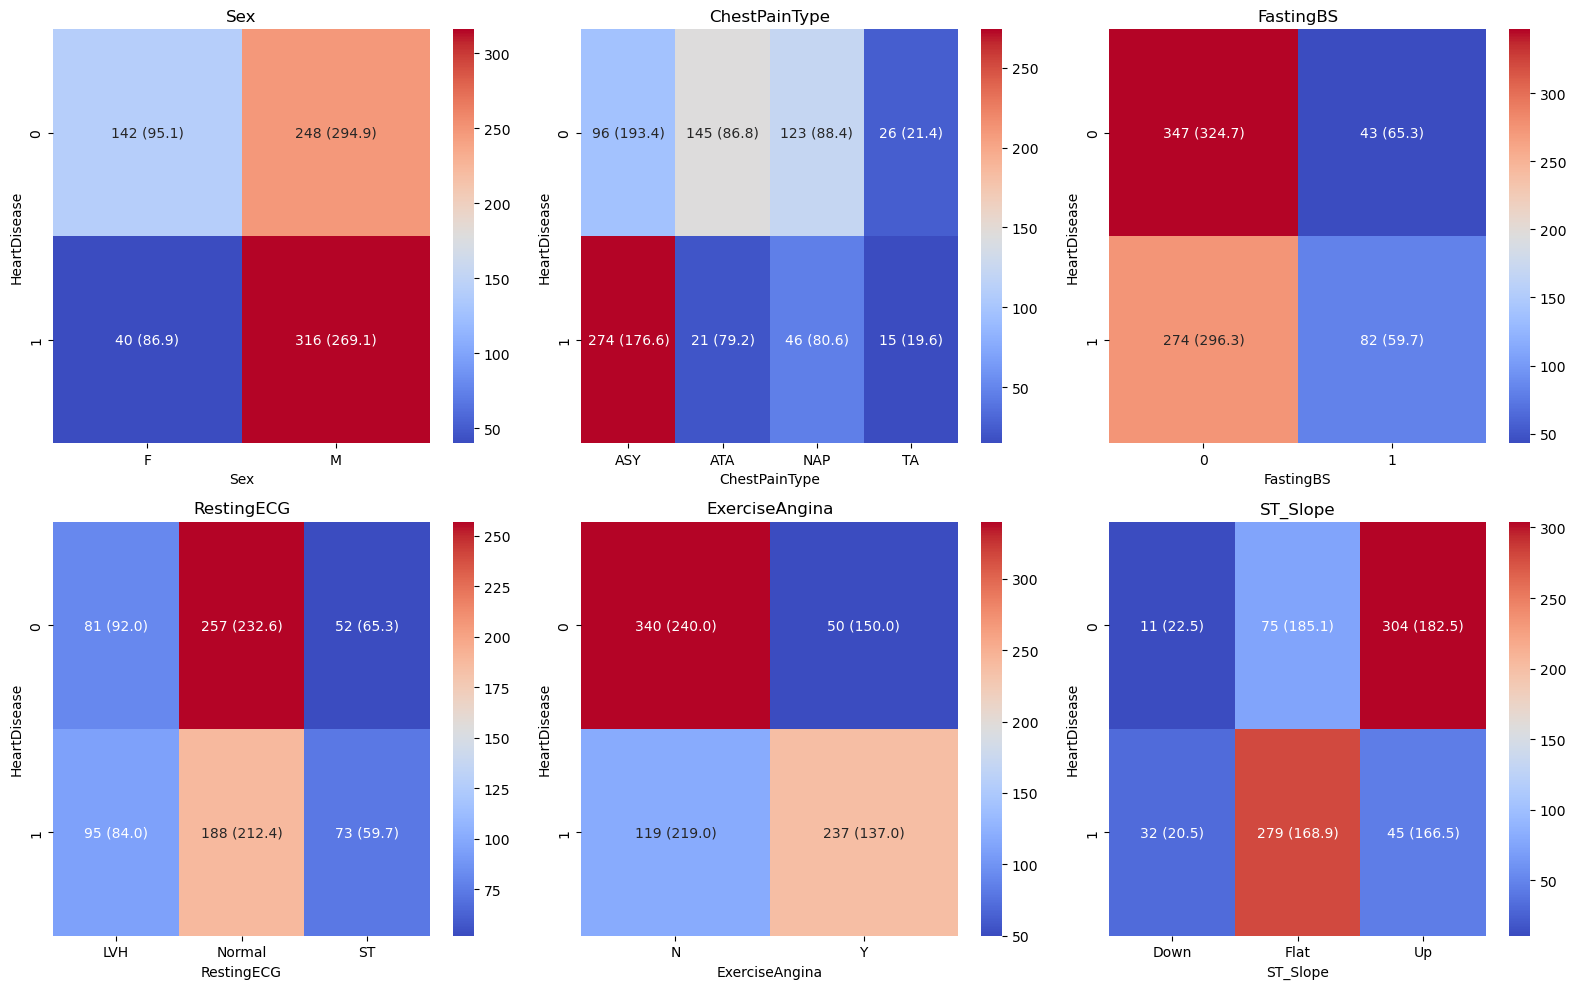

In [46]:
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

for i, col in enumerate(categorical):
    print(f"Analisi per la variabile {col}")
    contingency_table_analysis(df_clean, "HeartDisease", col, axs[i // 3, i % 3])
    print("\n\n")
    axs[i // 3, i % 3].set_title(col)

plt.tight_layout()